In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
# %matplotlib qt5
%matplotlib inline

In [177]:
data_test = pd.read_csv('./cs-test.csv',index_col=0)

In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101503 entries, 1 to 101503
Data columns (total 11 columns):
SeriousDlqin2yrs                        0 non-null float64
RevolvingUtilizationOfUnsecuredLines    101503 non-null float64
age                                     101503 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    101503 non-null int64
DebtRatio                               101503 non-null float64
MonthlyIncome                           81400 non-null float64
NumberOfOpenCreditLinesAndLoans         101503 non-null int64
NumberOfTimes90DaysLate                 101503 non-null int64
NumberRealEstateLoansOrLines            101503 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    101503 non-null int64
NumberOfDependents                      98877 non-null float64
dtypes: float64(5), int64(6)
memory usage: 9.3 MB


In [25]:
data_train = pd.read_csv('./cs-training.csv',index_col=0)

In [26]:
data_train.columns.sort_values()

Index(['DebtRatio', 'MonthlyIncome', 'NumberOfDependents',
       'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTime30-59DaysPastDueNotWorse',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'RevolvingUtilizationOfUnsecuredLines',
       'SeriousDlqin2yrs', 'age'],
      dtype='object')

In [27]:
col_replace = {'SeriousDlqin2yrs':'target', ## 违约客户及超过90天逾期客户，bool型；
            'RevolvingUtilizationOfUnsecuredLines':'percentage', ## 贷款以及信用卡可用额度与总额度比例，百分比；
           'NumberOfOpenCreditLinesAndLoans':'open_loan', ## 开放式信贷和贷款数量，开放式贷款（分期付款如汽车贷款或抵押贷款）和信贷（如信用卡）的数量，整型；
           'NumberOfTimes90DaysLate':'90-', ## 90天逾期次数：借款者有90天或更高逾期的次数，整型；
           'NumberRealEstateLoansOrLines':'estate_loan', ## 不动产贷款或额度数量：抵押贷款和不动产放款包括房屋净值信贷额度，整型；
           'NumberOfTime60-89DaysPastDueNotWorse':'60-89', ## 60-89天逾期但不糟糕次数，整型；
           'NumberOfDependents':'Dependents', ## 家属数量：不包括本人在内的家属数量，整型；
           'NumberOfTime30-59DaysPastDueNotWorse':'30-59' ## 35-59天逾期但不糟糕次数，整型；
              }
data_train.rename(columns=col_replace,inplace=True)

In [28]:
data_train.head()

,target,percentage,age,30-59,DebtRatio,MonthlyIncome,open_loan,90-,estate_loan,60-89,Dependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [29]:
data_train.info() ## 说明只有两项有缺失值

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
target           150000 non-null int64
percentage       150000 non-null float64
age              150000 non-null int64
30-59            150000 non-null int64
DebtRatio        150000 non-null float64
MonthlyIncome    120269 non-null float64
open_loan        150000 non-null int64
90-              150000 non-null int64
estate_loan      150000 non-null int64
60-89            150000 non-null int64
Dependents       146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


## 重复值

In [30]:
data_train.duplicated().sum()

609

In [31]:
data_train.drop_duplicates(inplace=True)

## 缺失值

In [32]:
data_train.loc[data_train.MonthlyIncome.isna(),'Dependents'].isna().mean()

0.13100167687621916

In [33]:
data_train.loc[data_train.Dependents.isna(),'MonthlyIncome'].isna().mean() ## 结果1，说明家属没填的，月收入都没填。

1.0

In [34]:
data_train.dropna(subset=['Dependents'],inplace=True) ## 去掉两项都缺的项。

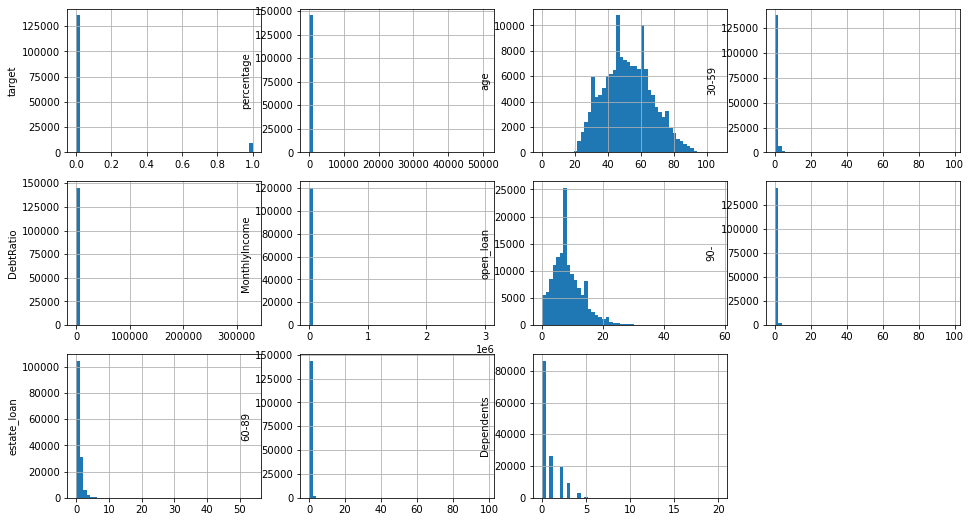

In [36]:
## 考察其他项有什么特征
plt.figure(figsize=(16,9))
for i,col in enumerate(data_train.columns):
    plt.subplot(3,4,i+1)
    data_train[col].hist(bins=50)
    plt.ylabel(col)

(array([ 7830., 19028., 24132., 21627., 14975., 11265.,  7993.,  4405.,
         2623.,  1762.]),
 array([    0. ,  1599.9,  3199.8,  4799.7,  6399.6,  7999.5,  9599.4,
        11199.3, 12799.2, 14399.1, 15999. ]),
 <a list of 10 Patch objects>)

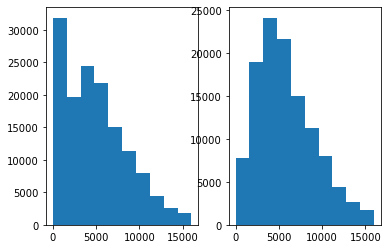

In [38]:
## 填充缺失值
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import KNNImputer
miss_imputer = IterativeImputer(ExtraTreesRegressor(10),initial_strategy="most_frequent",max_iter=5)
# miss_imputer2 = KNNImputer()
data_train_bak = data_train.copy()
data_train_bak.iloc[:,:-1]=miss_imputer.fit_transform(X=data_train.iloc[:,:-1])

plt.subplot(121)
plt.hist(data_train_bak.loc[data_train_bak.MonthlyIncome<16000,'MonthlyIncome'])
plt.subplot(122)
plt.hist(data_train.loc[data_train.MonthlyIncome<16000,'MonthlyIncome'])
## 填充结果改变了数据分布，不采用。

In [39]:
## 有缺失值的两列均改用未缺失项随机抽样填充
fill_len = data_train.MonthlyIncome.isna().sum()
data_train.loc[data_train.MonthlyIncome.isna(),'MonthlyIncome']=\
np.random.choice(data_train.loc[data_train.MonthlyIncome.notna(),'MonthlyIncome'],fill_len,False)

In [40]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145563 entries, 1 to 150000
Data columns (total 11 columns):
target           145563 non-null int64
percentage       145563 non-null float64
age              145563 non-null int64
30-59            145563 non-null int64
DebtRatio        145563 non-null float64
MonthlyIncome    145563 non-null float64
open_loan        145563 non-null int64
90-              145563 non-null int64
estate_loan      145563 non-null int64
60-89            145563 non-null int64
Dependents       145563 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.3 MB


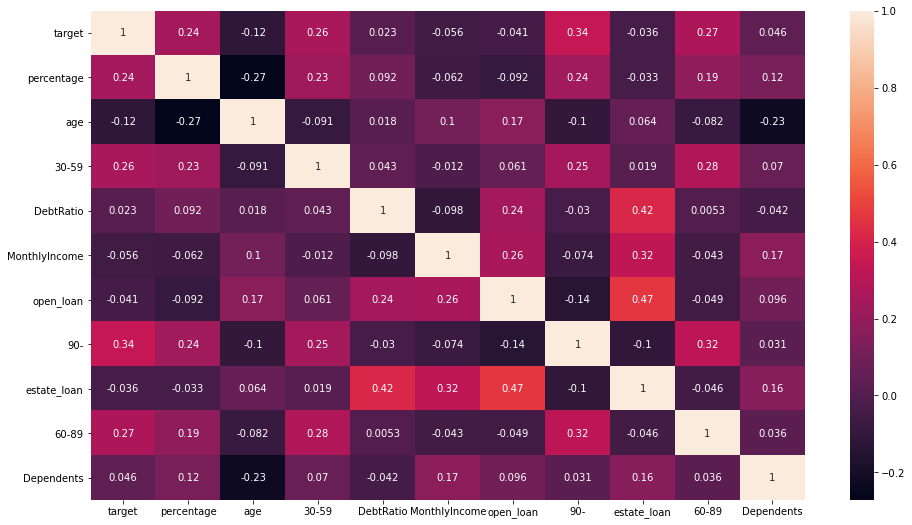

In [41]:
plt.figure(figsize=(16,9))
sns.heatmap(data_train.corr(method='spearman'),annot=True)
## 无>0.5的相关性, 暂不考虑降维

In [42]:
## 特征工程前，重置索引
data_train.reset_index(drop=True, inplace=True)

## 划分训练集验证集

In [43]:
from sklearn.model_selection import train_test_split

In [53]:
df_train, df_test = train_test_split(data_train,stratify=data_train.target)

## 自定分箱 卡方分箱 spearman分箱

In [54]:
import scipy

In [55]:
def init_box(df,n_split):
    ## 待份变量等频初始化分箱，统计分箱后标签频数
    categ = pd.cut(df.iloc[:,0],n_split,duplicates='raise')
    freq = pd.crosstab(categ, df.iloc[:,1]).reset_index()
    freq.iloc[:,0] = freq.iloc[:,0].astype(object)

    ## 计算WOE,IV
    freq['woe'] = np.log(freq[1]/freq[0]*freq[0].sum()/freq[1].sum())
    iv = freq.woe.dot((freq[1]/freq[1].sum()-freq[0]/freq[0].sum()))
    
    return freq.set_index(freq.columns[0]), iv ## reindex方便后续计算

In [56]:
def mychi2(freq):
    R = freq.sum(1,keepdims=True)
    C = freq.sum(0)
    N = R.sum()
    E = R*C / N
    sqr = np.square(freq-E)/E
    sqr[E==0] = 0
    return sqr.sum()

In [57]:
chi2 = lambda x: scipy.stats.chi2_contingency(x,correction=False)[1]
add = lambda in1,in2: pd.Interval(in1.left,in2.right)
def chi2_box(df, n_split=20, p_thr=.05):
    '''
    df:两列，第一列是待分箱变量，第二列是标签
    n_split: 初始划分区间数
    p_thr: 拒绝概率
    '''
    ## 待份变量等频初始化分箱，统计分箱后标签频数
    categ = pd.qcut(df.iloc[:,0],n_split,duplicates='drop')
    freq = pd.crosstab(categ, df.iloc[:,1]).reset_index()
    freq.iloc[:,0] = freq.iloc[:,0].astype(object)
    
    ## 相邻箱计算p值
    while True:
        p_val = [chi2(freq.iloc[i:i+2,1:]) for i in range(len(freq))]
        p_max = np.argmax(p_val[:-1])
        if p_val[p_max] <= p_thr:
            break
        freq.iloc[p_max,0] = add(freq.iloc[p_max,0], freq.iloc[p_max+1,0])
        freq.iloc[p_max,1:] = freq.iloc[p_max,1:] + freq.iloc[p_max+1,1:]
        freq.drop(index=freq.index[p_max+1],inplace=True)
    freq.iloc[-1,0] = add(freq.iloc[-1,0], pd.Interval(0,np.inf)) ## 适配数据
    freq.iloc[0,0] = add(pd.Interval(-np.inf,0), freq.iloc[0,0]) ## 适配数据

    ## 计算WOE,IV
    freq['p_val'] = p_val
    freq['woe'] = np.log(freq[1]/freq[0]*freq[0].sum()/freq[1].sum())
    iv = freq.woe.dot((freq[1]/freq[1].sum()-freq[0]/freq[0].sum()))
    
    return freq.set_index(freq.columns[0]),iv
    

(y                0     1          p_val       woe
 age                                              
 (-inf, 9.0]   9011   989  1.604685e-286 -1.809248
 (9.75, 29.0]  6959  3041  1.115745e-183 -0.427590
 (29.5, 44.0]  4953  5047  3.187757e-170  0.419060
 (44.25, inf]  3027  6973   1.000000e+00  1.234733,
 1.0379472405262833)

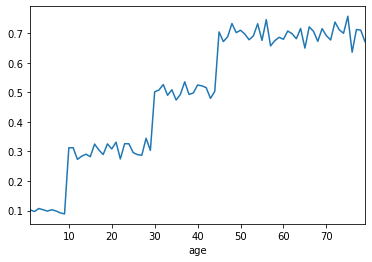

In [58]:
## test function 

num = 10000  ##构造一个有40000数据量的数据
x1 = np.random.randint(1,10,num)
x2 = np.random.randint(10,30,num)
x3 = np.random.randint(30,45,num)
x4 = np.random.randint(45,80,num)
x = np.r_[x1,x2,x3,x4]

y1 = np.random.choice([0,1],num,p=[.9,.1])
y2 = np.random.choice([0,1],num,p=[.7,.3])
y3 = np.random.choice([0,1],num,p=[.5,.5])
y4 = np.random.choice([0,1],num,p=[.3,.7])
y = np.r_[y1,y2,y3,y4]

testdata = pd.DataFrame({"age":x,"y":y})
testdata.groupby('age')['y'].mean().plot()
chi2_box(testdata,100,.001)

In [59]:
spearman = lambda x: scipy.stats.spearmanr(x.iloc[:,0], x.iloc[:,1])[0]
def spearman_box(df, n = 20, r_thr=1):
    r = 0
    while np.abs(r) < r_thr:
        categ = pd.qcut(df.iloc[:,0], n, duplicates='drop')
        d2 = df.groupby(categ).mean()
        r = spearman(d2)
        n = n - 1
    freq = pd.crosstab(categ, df.iloc[:,1]).reset_index()
    freq['woe'] = np.log(freq[1]/freq[0]*freq[0].sum()/freq[1].sum())
    iv = freq.woe.dot((freq[1]/freq[1].sum()-freq[0]/freq[0].sum()))
    return freq.set_index(freq.columns[0]),iv

target,0,1,p_val,woe
age,,,,
"(-inf, 35.0]",13805,1742,1.124320e-08,0.555179
"(35.0, 42.0]",13324,1352,3.949404e-07,0.337194
"(42.0, 54.0]",29456,2499,1.382729e-04,0.158169
"(54.0, 56.0]",4804,323,4.197696e-05,-0.074376
"(56.0, 62.0]",14177,719,4.288981e-09,-0.356339
"(62.0, 67.0]",10123,348,2.489703e-06,-0.745187
"(67.0, inf]",16110,390,1.000000e+00,-1.095873


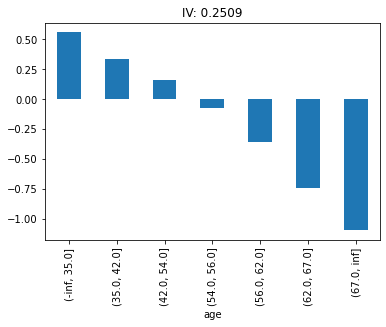

In [60]:
age_box,age_iv = chi2_box(df_train[['age','target']],50,.001)
display(age_box,age_box.woe.plot(kind='bar',title=f'IV: {age_iv:.4f}'))

target,0,1,p_val,woe
MonthlyIncome,,,,
"(-inf, 1300.0]",5139,339,5.315548e-12,-0.093438
"(1300.0, 3400.0]",19938,1995,5.507840e-05,0.323192
"(3400.0, 4560.0]",14974,1289,5.015111e-05,0.172727
"(4560.0, 6332.0]",20342,1492,6.019980e-10,0.012605
"(6332.0, 10109.35]",25790,1498,1.057793e-04,-0.220680
"(10109.35, inf]",15616,760,1.000000e+00,-0.397557


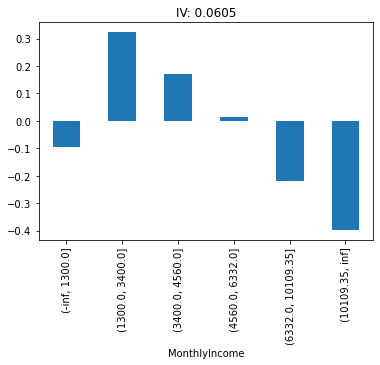

In [61]:
MI_box,MI_iv = chi2_box(df_train[['MonthlyIncome','target']],20,.01)
display(MI_box,MI_box.woe.plot(kind='bar',title=f'IV: {MI_iv:.4f}'))

target,0,1,p_val,woe
percentage,,,,
"(-inf, 0.00354]",10645,273,2.869790e-10,-1.038198
"(0.00354, 0.0627]",26870,422,2.694397e-04,-1.528585
"(0.0627, 0.118]",10690,227,5.711722e-06,-1.226938
"(0.118, 0.211]",10585,333,5.024018e-03,-0.833875
"(0.211, 0.276]",5246,212,1.555553e-04,-0.583459
"(0.276, 0.448]",10347,570,2.006255e-09,-0.273640
"(0.448, 0.562]",5045,414,5.142975e-06,0.124889
"(0.562, 0.699]",4909,549,2.155511e-10,0.434449
"(0.699, 0.851]",4694,765,4.361176e-18,0.811011


1.1406010896723342

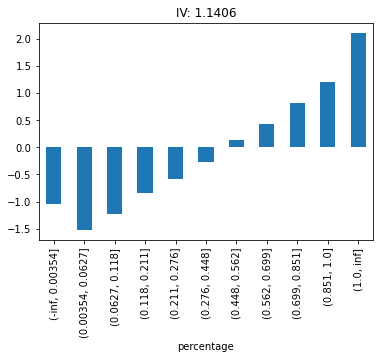

In [62]:
per_box,per_iv = chi2_box(df_train[['percentage','target']],20,.01)
display(per_box,per_iv,per_box.woe.plot(kind='bar',title=f'IV: {per_iv:.4f}'))

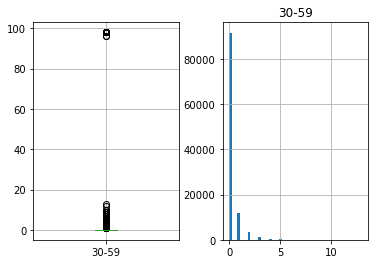

In [65]:
ax1 = plt.subplot(122)
df_train.loc[df_train['30-59'].lt(20),['30-59']].hist(ax=ax1,bins=50)
ax2=plt.subplot(121)
df_train[['30-59']].boxplot(ax=ax2)

In [66]:
n30_box,n30_iv = chi2_box(df_train[['30-59','target']],20,.05)
display(n30_box,n30_iv) ## 每箱数量差别太大，改手动分箱。

target,0,1,p_val,woe
30-59,,,,
"(-inf, 1.0]",97840,5473,0.000000e+00,-0.258331
"(1.0, 2.0]",2504,887,2.782438e-33,1.587376
"(2.0, inf]",1455,1013,1.000000e+00,2.263086


0.4870330365988019

target,0,1,woe
30-59,,,
"(-inf, 0.1]",87770,3695,-0.542564
"(0.1, 1.1]",10070,1778,0.891104
"(1.1, 2.1]",2504,887,1.587376
"(2.1, 3.1]",852,469,2.028192
"(3.1, 4.1]",320,244,2.354023
"(4.1, inf]",283,300,2.683511


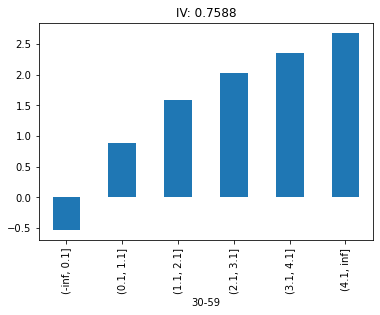

In [67]:
split = [-np.inf,.1,*np.arange(1.1,5,1),np.inf]
n30_box,n30_iv = init_box(df_train[['30-59','target']],split)
display(n30_box,n30_box.woe.plot(kind='bar',title=f'IV: {n30_iv:.4f}'))

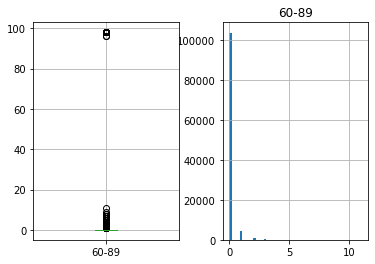

In [68]:
ax1 = plt.subplot(122)
df_train.loc[df_train['60-89'].lt(20),['60-89']].hist(ax=ax1,bins=50)
ax2=plt.subplot(121)
df_train[['60-89']].boxplot(ax=ax2)

In [69]:
n60_box,n60_iv = chi2_box(data_train[['60-89','target']],20,.05)
display(n60_box,n60_iv) ## 每箱数量差别太大，改手动分箱。

target,0,1,p_val,woe
60-89,,,,
"(-inf, 1.0]",134899,8876,0.0,-0.096034
"(1.0, inf]",833,955,1.0,2.761819


0.2600777758140071

target,0,1,woe
60-89,,,
"(-inf, 0.1]",98257,5331,-0.288872
"(0.1, 1.1]",2927,1321,1.829587
"(1.1, 2.1]",404,414,2.649627
"(2.1, 3.1]",99,134,2.927896
"(3.1, 5.1]",45,70,3.067008
"(5.1, inf]",67,103,3.055212


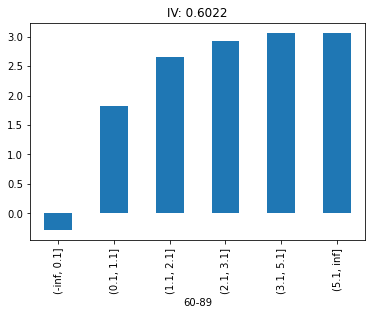

In [78]:
split = [-np.inf,.1,1.1, 2.1, 3.1,  5.1,np.inf]
n60_box,n60_iv = init_box(df_train[['60-89','target']],split)
display(n60_box,n60_box.woe.plot(kind='bar',title=f'IV: {n60_iv:.4f}'))

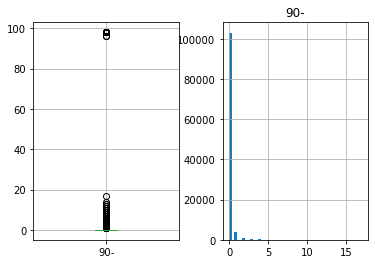

In [80]:
ax1 = plt.subplot(122)
df_train.loc[df_train['90-'].lt(20),['90-']].hist(ax=ax1,bins=50)
ax2=plt.subplot(121)
df_train[['90-']].boxplot(ax=ax2)

In [81]:
n90_box,n90_iv = chi2_box(data_train.loc[data_train.MonthlyIncome>1,['90-','target']],20,.05)
display(n90_box,n90_iv) ## 每箱数量差别太大，改手动分箱。

target,0,1,p_val,woe
90-,,,,
"(-inf, 1.0]",131855,8083,0.0,-0.174559
"(1.0, inf]",1307,1637,1.0,2.842512


0.4785089835547469

target,0,1,woe
90-,,,
"(-inf, 0.1]",98272,4828,-0.388131
"(0.1, 1.1]",2567,1315,1.956274
"(1.1, 2.1]",551,577,2.671283
"(2.1, 3.1]",208,276,2.908038
"(3.1, inf]",201,377,3.254116


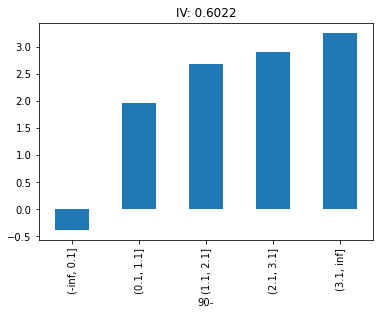

In [82]:
split = [-np.inf,.1,*np.arange(1.1,4,1),np.inf]
n90_box,n90_iv = init_box(df_train[['90-','target']],split)
display(n90_box,n90_box.woe.plot(kind='bar',title=f'IV: {n60_iv:.4f}')) ## 每箱数量差别太大，改手动分箱。

target,0,1,p_val,woe
DebtRatio,,,,
"(-inf, 0.00325]",4096,273,9.664519e-06,-0.083119
"(0.00325, 0.017]",4184,181,1.858064e-09,-0.515350
"(0.017, 0.226]",24495,1706,4.524071e-07,-0.039142
"(0.226, 0.312]",12417,684,1.068731e-06,-0.273688
"(0.312, 0.502]",20414,1420,3.706980e-12,-0.040388
"(0.502, 0.661]",7968,766,3.164217e-09,0.283169
"(0.661, 1.349]",7731,1002,8.045471e-19,0.581935
"(1.349, 690.0]",8079,659,1.932078e-12,0.118876
"(690.0, inf]",12415,682,1.000000e+00,-0.276455


0.06895234525965363

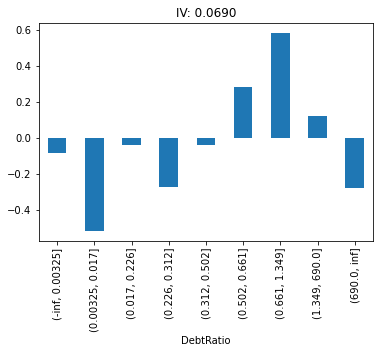

In [84]:
debt_box,debt_iv = chi2_box(df_train.loc[:,['DebtRatio','target']],25,.001)
display(debt_box,debt_iv)
debt_box.woe.plot(kind='bar',title=f'IV: {debt_iv:.4f}') ## 效果差，用手动分箱

D:\Program Files\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
D:\Program Files\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
D:\Program Files\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
D:\Program Files\Anaconda3\lib\site-packages\pandas\plottin

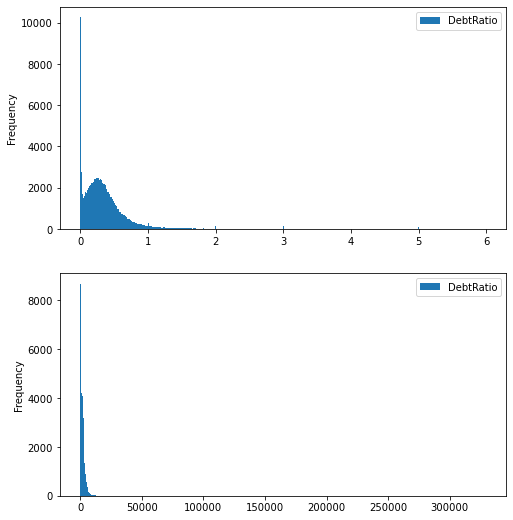

In [85]:
ax1 = plt.subplot(211)
data_train.query('6>DebtRatio')[['DebtRatio']].plot(kind='hist',ax=ax1, bins=500,figsize=(8,9))
## 0.04之前有异常，单独分一个箱
ax2 = plt.subplot(212)
data_train.query('6<=DebtRatio')[['DebtRatio']].plot(kind='hist',ax=ax2, bins=500,figsize=(8,9))
## 后面是一个长尾分布

target,0,1,woe
DebtRatio,,,
"(-inf, 0.08]",14503,934,-0.117459
"(0.08, 0.2]",14606,995,-0.061269
"(0.2, 0.3]",14435,833,-0.227202
"(0.3, 0.4]",12760,807,-0.135571
"(0.4, 0.5]",9162,685,0.031775
"(0.5, 0.6]",5718,525,0.237199
"(0.6, 0.7]",3654,390,0.387745
"(0.7, 0.8]",2270,303,0.611373
"(0.8, 0.9]",1459,181,0.538166


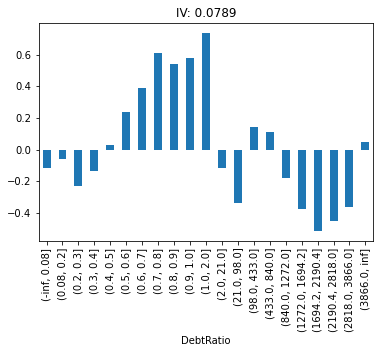

In [86]:
## 尝试多种分箱方法后的结果：
split = [-np.inf,.08,*np.arange(.2,1.1,.1),]
split2 = df_train.DebtRatio[data_train.DebtRatio.gt(2)].quantile(np.arange(10)/10).tolist()
b=split+split2+[np.inf]
debt_box,debt_iv = init_box(df_train.loc[:,['DebtRatio','target']],b)
# debt_box,debt_iv = init_box(data_train.loc[:,['DebtRatio','target']],b)
# debt_box,debt_iv = spearman_box(data_train.loc[:,['DebtRatio','target']],r_thr=.5)
display(debt_box)
debt_box.woe.plot(kind='bar',title=f'IV: {debt_iv:.4f}')

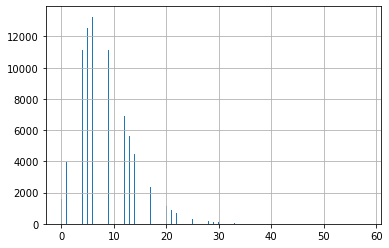

In [87]:
data_train.open_loan.hist(bins=500)

target,0,1,p_val,woe
open_loan,,,,
"(-inf, 2.0]",7593,1190,1.084787e-29,0.771902
"(2.0, 3.0]",5846,487,7.353274e-03,0.139927
"(3.0, 5.0]",16442,1179,1.642750e-05,-0.009997
"(5.0, 7.0]",18576,1106,1.922863e-02,-0.195945
"(7.0, 8.0]",8736,455,5.264401e-04,-0.329735
"(8.0, 14.0]",32543,2038,2.115155e-06,-0.145418
"(14.0, inf]",12063,918,1.000000e+00,0.049475


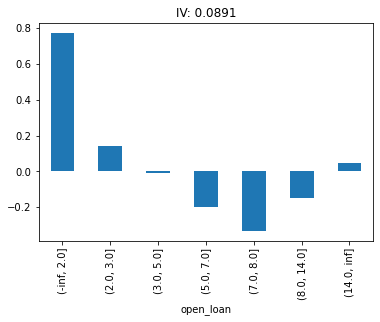

In [88]:
# loan_box,loan_iv = init_box(data_train.loc[:,['open_loan','target']],np.arange(15))
# loan_box,loan_iv = spearman_box(data_train.loc[:,['open_loan','target']],r_thr=.1)
loan_box,loan_iv = chi2_box(df_train.loc[:,['open_loan','target']])
display(loan_box)
loan_box.woe.plot(kind='bar',title=f'IV: {loan_iv:.4f}')

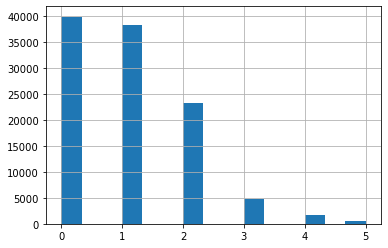

In [89]:
df_train.query('estate_loan<6').estate_loan.hist(bins=15)

target,0,1,woe
estate_loan,,,
"(-inf, 0.0]",36529,3406,0.252608
"(0.0, 1.0]",36382,2021,-0.265306
"(1.0, 2.0]",22064,1319,-0.191898
"(2.0, 3.0]",4415,316,-0.011845
"(3.0, 5.0]",1930,201,0.363205
"(5.0, inf]",479,110,1.153955


0.0702149443996638

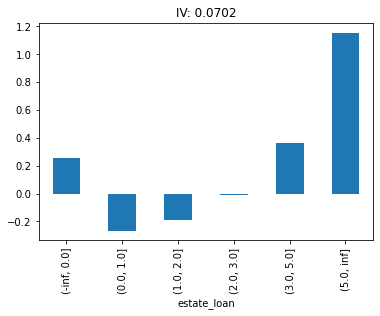

In [90]:
estate_box,estate_iv = init_box(df_train[['estate_loan','target']],
                               n_split = [-np.inf, 0, 1, 2, 3, 5, np.inf])
# estate_box,estate_iv = spearman_box(data_train[['estate_loan','target']],r_thr=.05)
display(estate_box,estate_iv)
estate_box.woe.plot(kind='bar',title=f'IV: {estate_iv:.4f}')

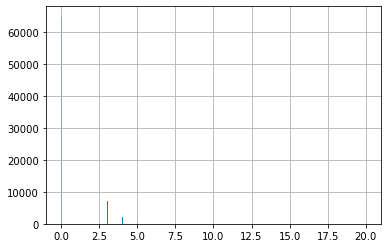

In [91]:
df_train.Dependents.hist(bins=500)

target,0,1,woe
Dependents,,,
"(-inf, 0.0]",60902,3827,-0.142009
"(0.0, 1.0]",18249,1420,0.071722
"(1.0, 2.0]",13603,1206,0.202194
"(2.0, 3.0]",6429,647,0.328948
"(3.0, 5.0]",2447,248,0.335986
"(5.0, inf]",169,25,0.714153


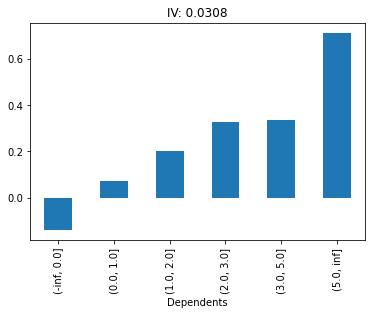

In [98]:
depend_box,depend_iv = init_box(df_train[['Dependents','target']],
                               n_split = [-np.inf, 0, 1, 2, 3, 5, np.inf])
# depend_box,depend_iv = chi2_box(data_train[['Dependents','target']])
display(depend_box)
depend_box.woe.plot(kind='bar',title=f'IV: {depend_iv:.4f}')

## WOE替换

In [100]:
woe_map = { 'percentage':per_box,
            'age':age_box,
            '30-59':n30_box,
            'DebtRatio':debt_box,
            'MonthlyIncome':MI_box,
            'open_loan':loan_box,
            '90-':n90_box,
            'estate_loan':estate_box,
            '60-89':n60_box,
            'Dependents':depend_box}
def woe_swag(df,woe=woe_map):
    df2={k:v.loc[df[k],'woe'].reset_index(drop=True) for k,v in woe.items()}
    df2['target'] = df.target.reset_index(drop=True)
    return pd.DataFrame(df2)

In [101]:
## 替换变量
data_train_bak = df_train.copy()
# data_train = data_train_bak.copy()

In [103]:
df_train = woe_swag(df_train)

In [107]:
df_train.head()

,percentage,age,30-59,DebtRatio,MonthlyIncome,open_loan,90-,estate_loan,60-89,Dependents,target
0,0.811011,0.555179,-0.542564,-0.061269,0.323192,-0.009997,-0.388131,0.252608,-0.288872,0.071722,0
1,-1.226938,0.158169,0.891104,-0.227202,-0.397557,-0.329735,-0.388131,-0.191898,-0.288872,0.202194,0
2,-1.528585,0.555179,-0.542564,-0.227202,-0.220680,-0.145418,-0.388131,-0.265306,-0.288872,-0.142009,0
3,-0.583459,-0.356339,2.028192,0.031775,-0.397557,0.049475,-0.388131,-0.191898,-0.288872,0.071722,0
4,-1.038198,0.158169,-0.542564,-0.117459,0.323192,0.139927,-0.388131,0.252608,-0.288872,-0.142009,0


In [203]:
df_test = woe_swag(df_test)

In [119]:
## 将正负样本SMOTE
# X, y = df_train.iloc[:,:-1].values, df_train.iloc[:,-1:].values
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=.5,n_jobs=-1)
X, y = smote.fit_resample(df_train.iloc[:,:-1], df_train.iloc[:,-1])

## 模型训练

In [241]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
my_scorer = make_scorer(roc_auc_score,needs_proba=True)
from sklearn.metrics import plot_roc_curve

In [120]:
ss = StandardScaler()
X = ss.fit_transform(X)
# X_test = ss.transform(X_test)

In [165]:
params = {'C':[100,10,1,.1,.01,.001,.0001],'penalty':['l1','l2'],'solver':['liblinear']}
lr = LogisticRegression()
clf = GridSearchCV(lr,params,n_jobs=-1,scoring=my_scorer)
clf.fit(X,y)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring=make_scorer(roc_auc_score, needs_proba=True))

In [166]:
display(clf.best_score_, clf.best_params_)

0.8571695765492956

{'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}

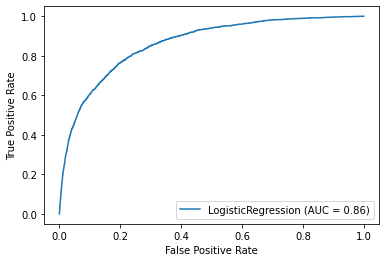

In [209]:
## 模型评估--auc
X_test = ss.transform(df_test.iloc[:,:-1])
_ = plot_roc_curve(clf.best_estimator_,X_test,df_test.target.values)

In [239]:
## 模型评估--psi
def PSI(model, X_train,X_test):
    '''
    训练集样本分箱频率统计与待预测样本分箱频率统计的KL散度求和
    '''
    bins = np.arange(11)/10.0
    
    y_train = model.predict_proba(X_train)[:,1]
    train_count = pd.value_counts(y_train,sort=False,bins=bins,normalize=True)
    
    y_test = model.predict_proba(X_test)[:,1]
    test_count = pd.value_counts(y_test,sort=False,bins=bins,normalize=True)
    
    return ((train_count-test_count)*np.log(train_count/test_count)).sum()

In [240]:
## data_test3是下面计算结果，这里提前用一下
psi=PSI(clf.best_estimator_, ss.transform(df_train.iloc[:,:-1]), data_test3)*100
print(f'PSI= {psi:.4f}%, 低于10%, 模型稳定。')

PSI= 0.0201%, 低于10%, 模型稳定。


## 预测结果

In [179]:
data_test.rename(columns=col_replace,inplace=True)

In [180]:
## 准备测试集
data_test.isna().sum()

target           101503
percentage            0
age                   0
30-59                 0
DebtRatio             0
MonthlyIncome     20103
open_loan             0
90-                   0
estate_loan           0
60-89                 0
Dependents         2626
dtype: int64

In [181]:
fill_len = data_test.Dependents.isna().sum()
data_test.loc[data_test.Dependents.isna(),'Dependents']=\
np.random.choice(data_train_bak.loc[data_train_bak.Dependents.notna(),'Dependents'],fill_len,False)

In [182]:
fill_len = data_test.MonthlyIncome.isna().sum()
data_test.loc[data_test.MonthlyIncome.isna(),'MonthlyIncome']=\
np.random.choice(data_train_bak.loc[data_train_bak.MonthlyIncome.notna(),'MonthlyIncome'],fill_len,False)

In [183]:
data_test2 = woe_swag(data_test)

In [184]:
data_test2.head()

,percentage,age,30-59,DebtRatio,MonthlyIncome,open_loan,90-,estate_loan,60-89,Dependents,target
0,1.195279,0.158169,-0.542564,-0.061269,0.012605,-0.009997,-0.388131,0.252608,-0.288872,-0.142009,NaN
1,0.124889,-0.356339,-0.542564,0.237199,-0.220680,0.049475,-0.388131,0.363205,-0.288872,0.202194,NaN
2,-1.528585,-0.356339,-0.542564,0.387745,0.012605,-0.145418,-0.388131,-0.265306,-0.288872,0.202194,NaN
3,-0.273640,0.337194,0.891104,0.579276,0.323192,-0.195945,-0.388131,-0.191898,-0.288872,-0.142009,NaN
4,1.195279,0.555179,-0.542564,-0.117459,0.172727,-0.009997,-0.388131,0.252608,-0.288872,0.071722,NaN


In [185]:
data_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 11 columns):
percentage       101503 non-null float64
age              101503 non-null float64
30-59            101503 non-null float64
DebtRatio        101503 non-null float64
MonthlyIncome    101503 non-null float64
open_loan        101503 non-null float64
90-              101503 non-null float64
estate_loan      101503 non-null float64
60-89            101503 non-null float64
Dependents       101503 non-null float64
target           0 non-null float64
dtypes: float64(11)
memory usage: 8.5 MB


In [186]:
data_test3 = ss.transform(data_test2.iloc[:,:-1])

In [196]:
y_hat = clf.best_estimator_.predict_proba(data_test3)[:,1]

In [200]:
to_push = pd.DataFrame({'Id':data_test.index.tolist(),
                        'Probability':y_hat})
to_push.to_csv('submission.csv', index=False)

## 评分规则建立

In [310]:
## 确定阈值--KS检验
def KS(model, X, y):
    y_prob = model.predict_proba(X)[:,1]
    df = pd.DataFrame(roc_curve(y, y_prob),index=['fpr','tpr','thre']).T
    df['gap'] = df.tpr - df.fpr
    ks = df.gap.max()
    fpr_max, tpr_max, thre, _  = df.loc[df.gap.idxmax(),:]
    
    df.plot(x='thre',y=['fpr','tpr'],xlim=(0,1),
           title=f'KS: {ks:.4f}, thre: {thre:.4f}')
    plt.vlines(thre,fpr_max,tpr_max,color='r')
    
    return thre

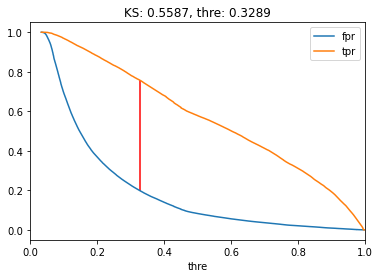

In [311]:
thre = KS(clf.best_estimator_, X, y)
## 阈值0.3289,大于即违约

In [325]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit([[thre], [1]],[60,100])
print(f'y = {lr.coef_[0]:.4f} * X + {lr.intercept_:.4f}')

y = 59.6049 * X + 40.3951
